<a href="https://colab.research.google.com/github/mashruravi/eip-hvc/blob/master/colab/Person_Attributes_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
!cp /content/gdrive/My\ Drive/hvc_encoded_3.csv /content/
# `hvc_encoded.csv` and `resized` should be available
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  hvc_encoded_3.csv  resized/  sample_data/


In [0]:
import pandas as pd

In [4]:
df = pd.read_csv('hvc_encoded_3.csv')
df.head()

,image_path,gender_female,gender_male,qual_Average,qual_Bad,qual_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,bag_Daily/Office/Work Bag,bag_Grocery/Home/Plastic Bag,bag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
0,resized/1.jpg,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
1,resized/2.jpg,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
2,resized/3.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
3,resized/4.jpg,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4,resized/5.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.15)

In [6]:
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
# Columns for one-hot encoded labels
def get_columns_by_prefix(prefix):
  return [col for col in df if col.startswith(prefix)]

_gender_columns = get_columns_by_prefix('gender')
_qual_columns_ = get_columns_by_prefix('qual')
_age_columns_ = get_columns_by_prefix('age')
_weight_columns_ = get_columns_by_prefix('weight')
_bag_columns_ = get_columns_by_prefix('bag')
_footwear_columns_ = get_columns_by_prefix('footwear')
_emotion_columns_ = get_columns_by_prefix('emotion')
_bodypose_columns_ = get_columns_by_prefix('bodypose')

In [8]:
import tensorflow
print(tensorflow.__version__)

1.15.0


In [9]:
import keras
import numpy as np
import cv2
from __future__ import division

class DataGenerator(tensorflow.keras.utils.Sequence):
  
  def __init__(self, df, batch_size=32, shuffle=True):
    self.df = df
    self.batch_size = batch_size
    self.shuffle = shuffle

  def __len__(self):
    return int(np.ceil(self.df.shape[0] / self.batch_size))

  def __getitem__(self, index):
    """ return X=224,224,3,batch_size and y=num_classes,batch_size"""
    batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
    items = self.df.iloc[batch_slice]
    images = np.stack([cv2.imread(item['image_path']) for _, item in items.iterrows()])
    images = images/255
    target = {
        'gender_output': items[_gender_columns].values,
        'imagequality_output': items[_qual_columns_].values,
        'age_output': items[_age_columns_].values,
        'weight_output': items[_weight_columns_].values,
        'bag_output': items[_bag_columns_].values,
        'footwear_output': items[_footwear_columns_].values,
        'emotion_output': items[_emotion_columns_].values,
        'bodypose_output': items[_bodypose_columns_].values
    }
    return images, target

  def on_epoch_end(self):
    """Shuffle data after each epoch"""
    if self.shuffle == True:
      self.df = self.df.sample(frac=1).reset_index(drop=True)

Using TensorFlow backend.


In [0]:
BATCH_SIZE=16
train_gen = DataGenerator(train_df, batch_size=BATCH_SIZE, shuffle=True)
valid_gen = DataGenerator(val_df, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
images, targets = next(iter(train_gen))

In [12]:
def get_unit_count(value_output):
  if (len(value_output.shape) > 1):
    return value_output.shape[1]
  else:
    return 1
num_units = { k.split("_output")[0]: get_unit_count(v) for k, v in targets.items() }
num_units

{'age': 5,
 'bag': 3,
 'bodypose': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'imagequality': 3,
 'weight': 4}

In [0]:
from __future__ import division

import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten,
    Dropout
)
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    GlobalAveragePooling2D
)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


weight_decay = 0.005

def initial_conv(input, i):
    x = Conv2D(100, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name=f"conv_init_{i}")(input)

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name=f"BN_init_{i}")(x)
    x = Activation('relu')(x)
    return x


def expand_conv(idx, init, base, k, strides=(1, 1)):
    x = Conv2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_1")(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN_expand"+str(idx))(x)
    x = Activation('relu')(x)

    x = Conv2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_2")(x)

    skip = Conv2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv_expand_"+str(idx)+"_3")(init)

    m = add([x, skip])

    return m


def conv1_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN1_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv1_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN1_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv1_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def conv2_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN2_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv2_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN2_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False,name="conv2_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def conv3_block(idx, input, k=1, dropout=0.0):
    init = input

    channel_axis = -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN3_"+str(idx)+"_1")(input)
    x = Activation('relu')(x)
    x = Conv2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv3_"+str(idx)+"_1")(x)

    if dropout > 0.0: x = Dropout(rate=dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name="BN3_"+str(idx)+"_2")(x)
    x = Activation('relu')(x)
    x = Conv2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False, name="conv3_"+str(idx)+"_2")(x)

    m = add([init, x])
    return m

def create_wide_residual_network(input_layer, N=2, k=1, dropout=0.0, verbose=1, index=0):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = input_layer

    x = initial_conv(ip, index)
    nb_conv = 4

    x = expand_conv(f"{index}_1", x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(f"{index}_i", x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name=f"BN_{index}_1")(x)
    x = Activation('relu')(x)

    x = expand_conv(f"{index}_2", x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(f"{index}_i", x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name=f"BN_{index}_2")(x)
    x = Activation('relu')(x)

    x = expand_conv(f"{index}_3", x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(f"{index}_i", x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform', name=f"BN_{index}_3")(x)
    x = Activation('relu')(x)

    return x

    # x = Conv2D(nb_classes, (1,1), padding="same", name="conv_final")(x)
    # x = GlobalAveragePooling2D(name="GAP")(x)
    # x = Activation("softmax")(x)

    # model = Model(ip, x)

    # if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    # return model

In [0]:
def get_backbone(input_layer):
  # return create_wide_residual_network(input_layer, N=1, k=1, dropout=0.0, verbose=1, index=0)
  x = Conv2D(16, (3, 3), use_bias=False)(input_layer)
  x = Conv2D(16, (3, 3), use_bias=False)(x)
  x = MaxPooling2D(strides=2)(x)

  x = Conv2D(32, (3, 3), use_bias=False)(x)
  x = Conv2D(32, (3, 3), use_bias=False)(x)
  x = MaxPooling2D(strides=2)(x)

  x = Conv2D(64, (3, 3), use_bias=False)(x)
  x = Conv2D(64, (3, 3), use_bias=False)(x)
  x = Conv2D(64, (3, 3), use_bias=False)(x)
  x = MaxPooling2D(strides=2)(x)

  x = Conv2D(128, (3, 3), use_bias=False)(x)
  x = Conv2D(128, (3, 3), use_bias=False)(x)
  x = Conv2D(128, (3, 3), use_bias=False)(x)
  x = MaxPooling2D(strides=2)(x)
  return x

def get_neck(input_layer, index):
  # x = create_wide_residual_network(input_layer, N=1, k=1, dropout=0.0, verbose=1, index=index)

  x = Conv2D(64, (1, 1))(input_layer)
  x = Conv2D(64, (3, 3))(x)
  x = Conv2D(64, (3, 3))(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dropout(rate=0.2)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(rate=0.2)(x)
  x = Dense(64, activation='relu')(x)
  return x

def get_head(name, input_layer):
  return Dense(num_units[name], activation='softmax', name=f'{name}_output')(input_layer)

def make_model():

  input = Input(shape=(224, 224, 3))

  backbone = get_backbone(input)


  # heads
  age = get_head('age', get_neck(backbone, 1))
  bag = get_head('bag', get_neck(backbone, 2))
  bodypose = get_head('bodypose', get_neck(backbone, 3))
  emotion = get_head('emotion', get_neck(backbone, 4))
  footwear = get_head('footwear', get_neck(backbone, 5))
  gender = get_head('gender', get_neck(backbone, 6))
  imagequality = get_head('imagequality', get_neck(backbone, 7))
  weight = get_head('weight', get_neck(backbone, 8))

  model = Model(
      inputs = input,
      outputs = [age, bag, bodypose, emotion, footwear, gender, imagequality, weight]
  )

  return model

In [0]:
def get_compiled_model():

  model = make_model()

  model.compile(
      optimizer='sgd',
      loss={
          'gender_output': 'categorical_crossentropy',
          'imagequality_output': 'categorical_crossentropy',
          'age_output': 'categorical_crossentropy',
          'weight_output': 'categorical_crossentropy',
          'bag_output': 'categorical_crossentropy',
          'footwear_output': 'categorical_crossentropy',
          'emotion_output': 'categorical_crossentropy',
          'bodypose_output': 'categorical_crossentropy'
      },
      metrics=["accuracy"]
  )
  return model


In [16]:
model = get_compiled_model()
# model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
from tensorflow.keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
clr = CyclicLR(base_lr=1e-12, max_lr=.1, step_size=14421)

In [19]:
history = model.fit_generator(
    generator=train_gen,
    # validation_data=valid_gen,
    epochs=20,
    callbacks=[clr]
)

Epoch 1/20
722/722 [==============================] - 42s 58ms/step - loss: 8.3182 - age_output_loss: 1.5072 - bag_output_loss: 0.9981 - bodypose_output_loss: 0.9695 - emotion_output_loss: 1.0400 - footwear_output_loss: 1.0363 - gender_output_loss: 0.6831 - imagequality_output_loss: 1.0023 - weight_output_loss: 1.0817 - age_output_acc: 0.3427 - bag_output_acc: 0.4847 - bodypose_output_acc: 0.6031 - emotion_output_acc: 0.6643 - footwear_output_acc: 0.4668 - gender_output_acc: 0.5482 - imagequality_output_acc: 0.5507 - weight_output_acc: 0.5980
Epoch 2/20
722/722 [==============================] - 33s 46ms/step - loss: 7.8170 - age_output_loss: 1.4288 - bag_output_loss: 0.9297 - bodypose_output_loss: 0.9225 - emotion_output_loss: 0.9347 - footwear_output_loss: 0.9619 - gender_output_loss: 0.6569 - imagequality_output_loss: 0.9819 - weight_output_loss: 1.0005 - age_output_acc: 0.3956 - bag_output_acc: 0.5607 - bodypose_output_acc: 0.6180 - emotion_output_acc: 0.7094 - footwear_output_acc:

KeyboardInterrupt: ignored

LR range vs iteration


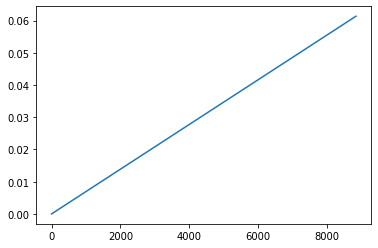

Loss vs LR


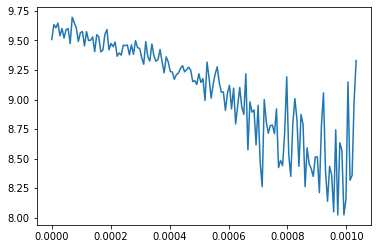

Individual Loss vs LR


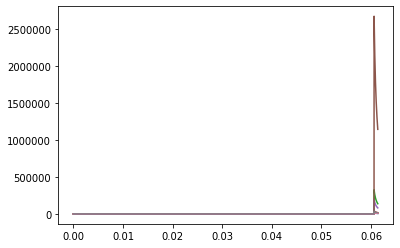

In [26]:
lr = clr.history['lr']
loss = clr.history['loss']

losses = [
  clr.history['age_output_loss'],
  clr.history['bag_output_loss'],
  clr.history['bodypose_output_loss'],
  clr.history['emotion_output_loss'],
  clr.history['footwear_output_loss'],
  clr.history['gender_output_loss'],
  clr.history['imagequality_output_loss'],
  clr.history['weight_output_loss']
]

import matplotlib.pyplot as plt

print('LR range vs iteration')
plt.plot(range(len(lr)), lr)
plt.show()

print('Loss vs LR')
items=150
plt.plot(lr[:items], loss[:items])
plt.show()

print('Individual Loss vs LR')
for loss in losses:
  plt.plot(lr, loss)
plt.show()

In [27]:
clr = CyclicLR(base_lr=0.0001, max_lr=0.0006, step_size=5000)
model = get_compiled_model()
history = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=[clr]
)

Epoch 1/20
722/722 [==============================] - 41s 57ms/step - loss: 8.8285 - age_output_loss: 1.5354 - bag_output_loss: 1.0461 - bodypose_output_loss: 1.0101 - emotion_output_loss: 1.2074 - footwear_output_loss: 1.0907 - gender_output_loss: 0.6883 - imagequality_output_loss: 1.0444 - weight_output_loss: 1.2062 - age_output_acc: 0.3376 - bag_output_acc: 0.4727 - bodypose_output_acc: 0.5486 - emotion_output_acc: 0.5320 - footwear_output_acc: 0.3679 - gender_output_acc: 0.5381 - imagequality_output_acc: 0.5180 - weight_output_acc: 0.5918 - val_loss: 8.0140 - val_age_output_loss: 1.4601 - val_bag_output_loss: 0.9384 - val_bodypose_output_loss: 0.9331 - val_emotion_output_loss: 0.9510 - val_footwear_output_loss: 1.0429 - val_gender_output_loss: 0.6636 - val_imagequality_output_loss: 0.9874 - val_weight_output_loss: 1.0376 - val_age_output_acc: 0.4042 - val_bag_output_acc: 0.5693 - val_bodypose_output_acc: 0.6149 - val_emotion_output_acc: 0.7250 - val_footwear_output_acc: 0.4224 - va

In [0]:
history.history.keys()

dict_keys(['loss', 'age_output_loss', 'bag_output_loss', 'bodypose_output_loss', 'emotion_output_loss', 'footwear_output_loss', 'gender_output_loss', 'imagequality_output_loss', 'weight_output_loss', 'age_output_acc', 'bag_output_acc', 'bodypose_output_acc', 'emotion_output_acc', 'footwear_output_acc', 'gender_output_acc', 'imagequality_output_acc', 'weight_output_acc', 'val_loss', 'val_age_output_loss', 'val_bag_output_loss', 'val_bodypose_output_loss', 'val_emotion_output_loss', 'val_footwear_output_loss', 'val_gender_output_loss', 'val_imagequality_output_loss', 'val_weight_output_loss', 'val_age_output_acc', 'val_bag_output_acc', 'val_bodypose_output_acc', 'val_emotion_output_acc', 'val_footwear_output_acc', 'val_gender_output_acc', 'val_imagequality_output_acc', 'val_weight_output_acc'])

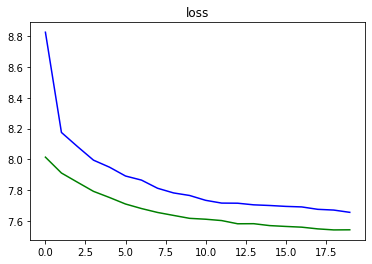

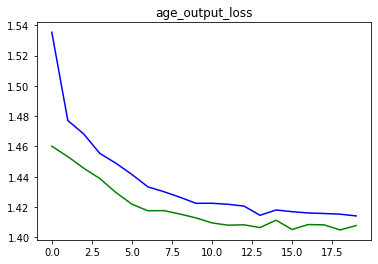

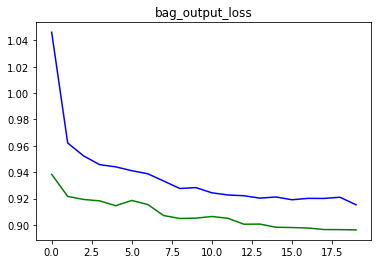

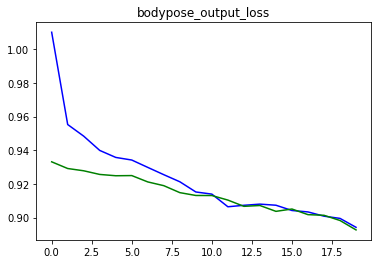

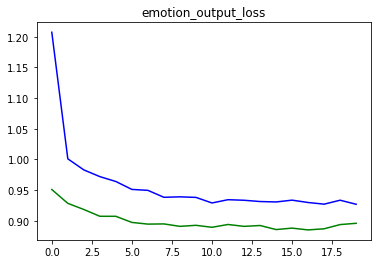

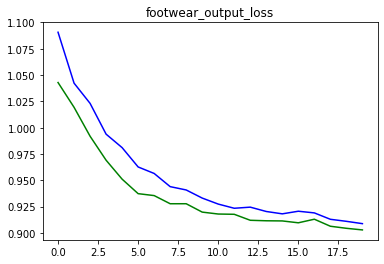

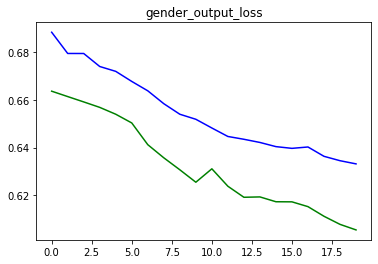

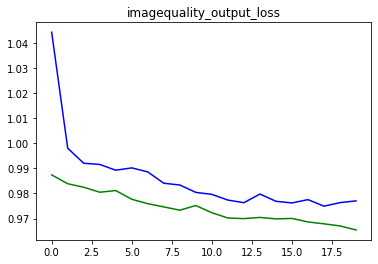

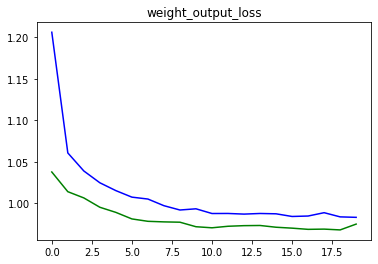

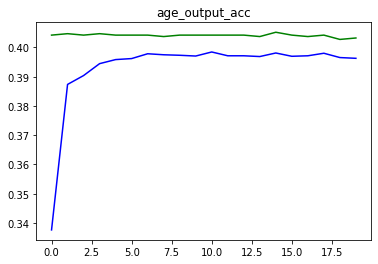

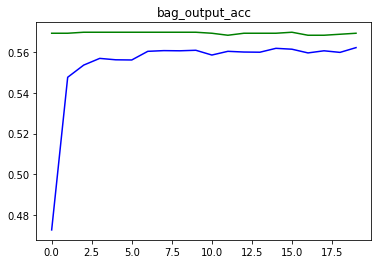

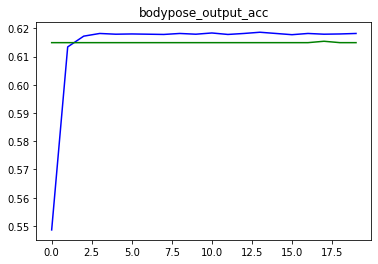

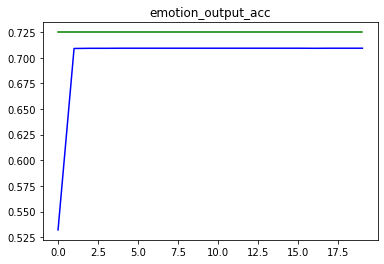

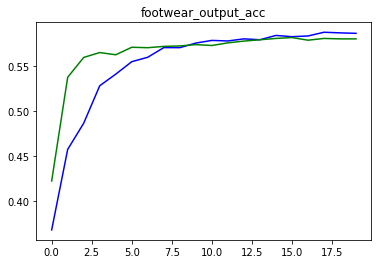

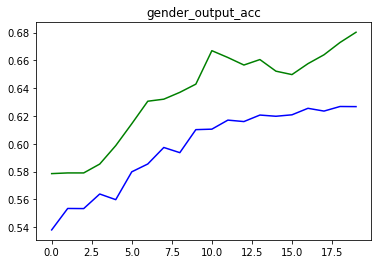

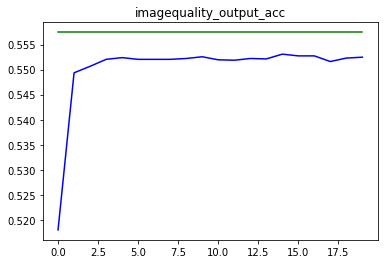

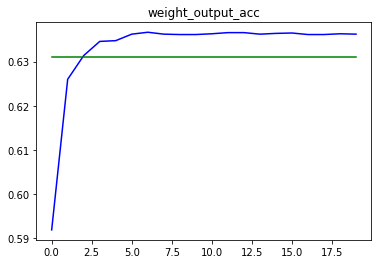

In [28]:

def plot(metric):
  loss = history.history[metric]
  val_loss = history.history[f'val_{metric}']

  plt.plot(range(len(loss)), loss, color='blue')
  plt.plot(range(len(val_loss)), val_loss, color='green')
  plt.title(metric)
  plt.show()


metrics = ['loss', 'age_output_loss', 'bag_output_loss', 'bodypose_output_loss', 'emotion_output_loss', 'footwear_output_loss', 'gender_output_loss', 'imagequality_output_loss', 'weight_output_loss', 'age_output_acc', 'bag_output_acc', 'bodypose_output_acc', 'emotion_output_acc', 'footwear_output_acc', 'gender_output_acc', 'imagequality_output_acc', 'weight_output_acc']
for metric in metrics:
  plot(metric)

In [29]:
clr = CyclicLR(base_lr=0.0006, max_lr=0.001, step_size=5000)
history2 = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=[clr]
)

Epoch 1/20
722/722 [==============================] - 38s 53ms/step - loss: 7.6377 - age_output_loss: 1.4178 - bag_output_loss: 0.9148 - bodypose_output_loss: 0.8933 - emotion_output_loss: 0.9233 - footwear_output_loss: 0.9029 - gender_output_loss: 0.6299 - imagequality_output_loss: 0.9735 - weight_output_loss: 0.9821 - age_output_acc: 0.3976 - bag_output_acc: 0.5622 - bodypose_output_acc: 0.6184 - emotion_output_acc: 0.7094 - footwear_output_acc: 0.5878 - gender_output_acc: 0.6342 - imagequality_output_acc: 0.5524 - weight_output_acc: 0.6368 - val_loss: 7.5239 - val_age_output_loss: 1.4035 - val_bag_output_loss: 0.8942 - val_bodypose_output_loss: 0.8891 - val_emotion_output_loss: 0.8912 - val_footwear_output_loss: 0.9004 - val_gender_output_loss: 0.6027 - val_imagequality_output_loss: 0.9649 - val_weight_output_loss: 0.9778 - val_age_output_acc: 0.4032 - val_bag_output_acc: 0.5697 - val_bodypose_output_acc: 0.6149 - val_emotion_output_acc: 0.7250 - val_footwear_output_acc: 0.5815 - va

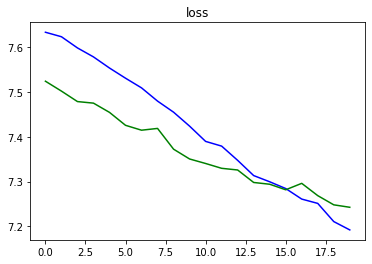

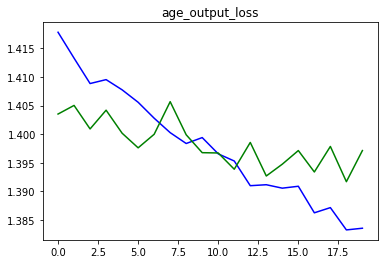

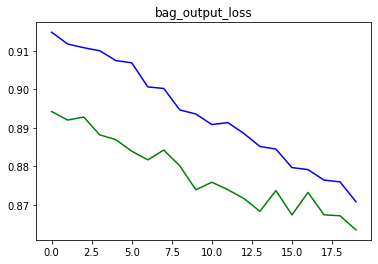

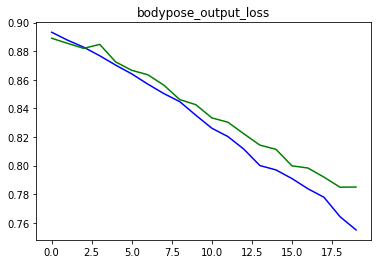

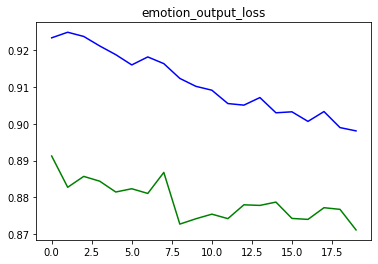

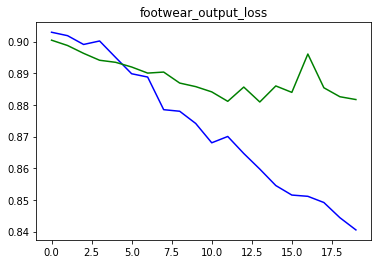

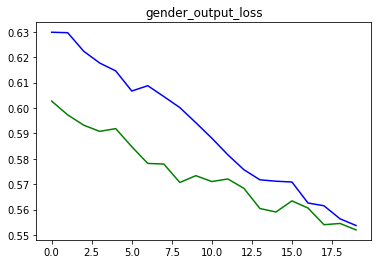

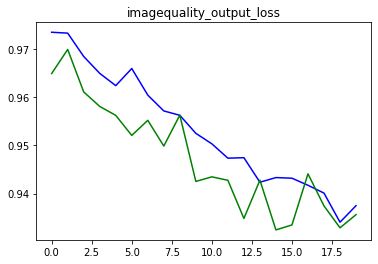

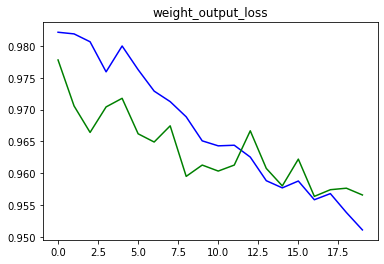

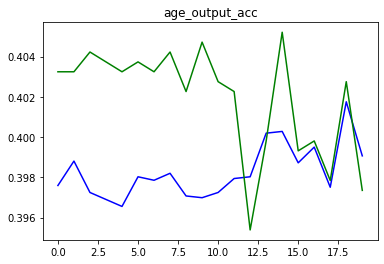

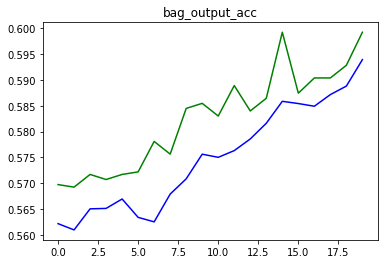

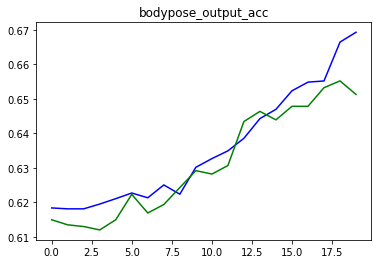

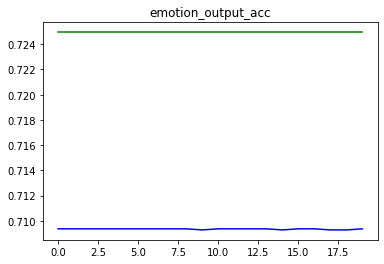

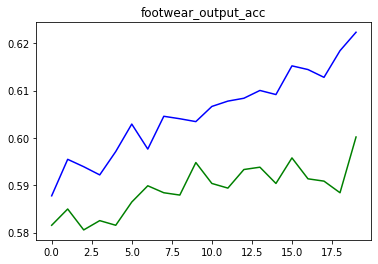

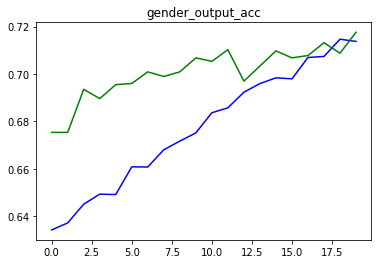

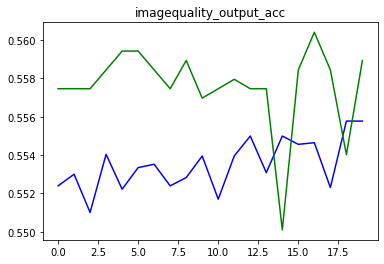

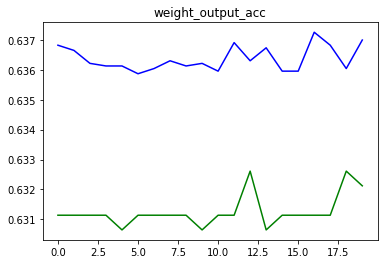

In [31]:

def plot2(metric):
  loss = history2.history[metric]
  val_loss = history2.history[f'val_{metric}']

  plt.plot(range(len(loss)), loss, color='blue')
  plt.plot(range(len(val_loss)), val_loss, color='green')
  plt.title(metric)
  plt.show()


metrics = ['loss', 'age_output_loss', 'bag_output_loss', 'bodypose_output_loss', 'emotion_output_loss', 'footwear_output_loss', 'gender_output_loss', 'imagequality_output_loss', 'weight_output_loss', 'age_output_acc', 'bag_output_acc', 'bodypose_output_acc', 'emotion_output_acc', 'footwear_output_acc', 'gender_output_acc', 'imagequality_output_acc', 'weight_output_acc']
for metric in metrics:
  plot2(metric)

In [32]:
history2 = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=60,
    callbacks=[clr]
)

Epoch 1/60
722/722 [==============================] - 38s 53ms/step - loss: 7.1573 - age_output_loss: 1.3797 - bag_output_loss: 0.8690 - bodypose_output_loss: 0.7479 - emotion_output_loss: 0.8955 - footwear_output_loss: 0.8387 - gender_output_loss: 0.5478 - imagequality_output_loss: 0.9302 - weight_output_loss: 0.9485 - age_output_acc: 0.4030 - bag_output_acc: 0.5955 - bodypose_output_acc: 0.6734 - emotion_output_acc: 0.7094 - footwear_output_acc: 0.6258 - gender_output_acc: 0.7173 - imagequality_output_acc: 0.5566 - weight_output_acc: 0.6375 - val_loss: 7.2643 - val_age_output_loss: 1.3923 - val_bag_output_loss: 0.8708 - val_bodypose_output_loss: 0.7674 - val_emotion_output_loss: 0.8743 - val_footwear_output_loss: 0.8858 - val_gender_output_loss: 0.5648 - val_imagequality_output_loss: 0.9518 - val_weight_output_loss: 0.9571 - val_age_output_acc: 0.4003 - val_bag_output_acc: 0.5869 - val_bodypose_output_acc: 0.6616 - val_emotion_output_acc: 0.7250 - val_footwear_output_acc: 0.5968 - va

In [0]:
import json

json_data = json.dumps(str(history.history))
f = open('history.json', 'w')
f.write(json_data)
f.close()

In [0]:
model.save_weights('weights.h5')

In [34]:
history2 = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=60,
    callbacks=[clr]
)

Epoch 1/60
722/722 [==============================] - 38s 53ms/step - loss: 3.4162 - age_output_loss: 0.8194 - bag_output_loss: 0.3946 - bodypose_output_loss: 0.1561 - emotion_output_loss: 0.5031 - footwear_output_loss: 0.3739 - gender_output_loss: 0.1354 - imagequality_output_loss: 0.5225 - weight_output_loss: 0.5113 - age_output_acc: 0.6665 - bag_output_acc: 0.8383 - bodypose_output_acc: 0.9410 - emotion_output_acc: 0.8072 - footwear_output_acc: 0.8422 - gender_output_acc: 0.9455 - imagequality_output_acc: 0.7766 - weight_output_acc: 0.7916 - val_loss: 11.3355 - val_age_output_loss: 1.8489 - val_bag_output_loss: 1.3597 - val_bodypose_output_loss: 1.4416 - val_emotion_output_loss: 1.3569 - val_footwear_output_loss: 1.4520 - val_gender_output_loss: 1.1822 - val_imagequality_output_loss: 1.2802 - val_weight_output_loss: 1.4139 - val_age_output_acc: 0.3414 - val_bag_output_acc: 0.5668 - val_bodypose_output_acc: 0.6852 - val_emotion_output_acc: 0.6611 - val_footwear_output_acc: 0.5530 - v

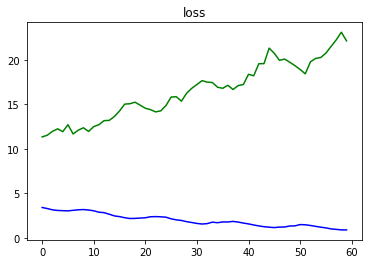

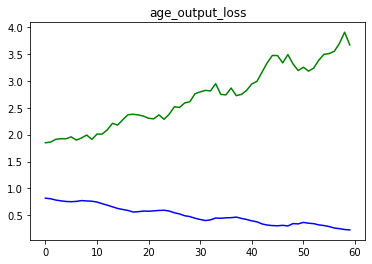

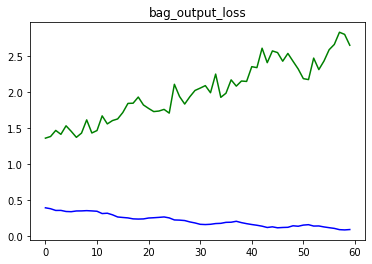

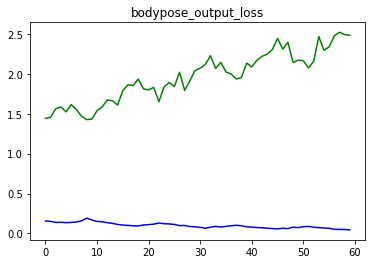

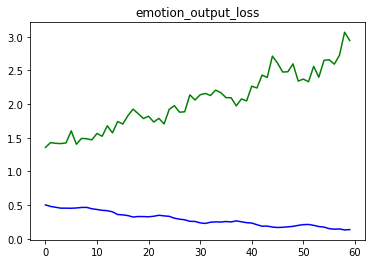

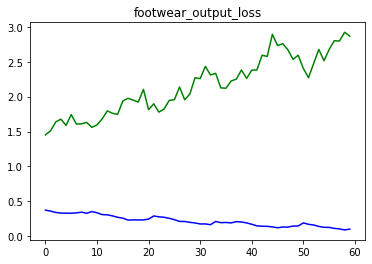

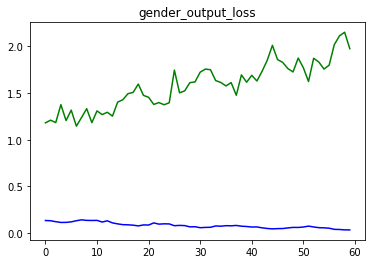

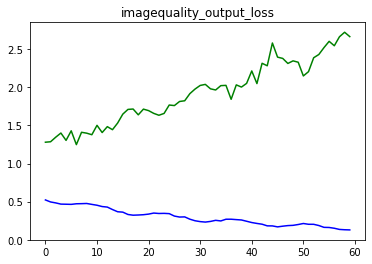

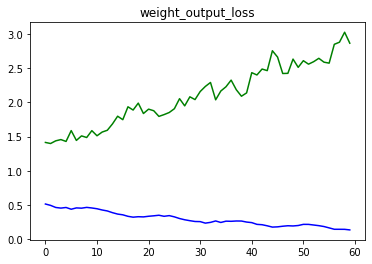

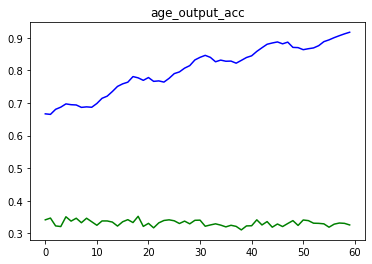

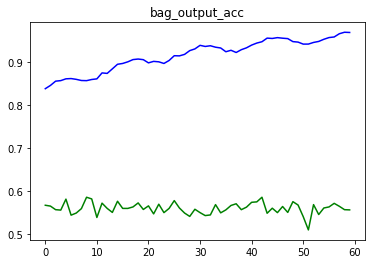

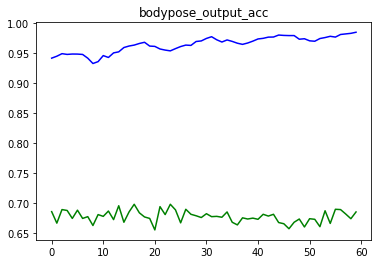

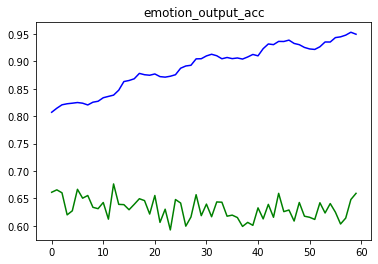

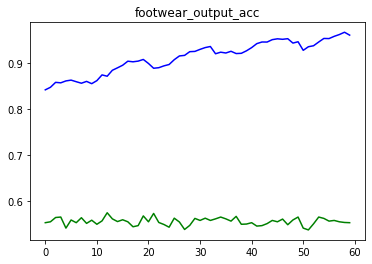

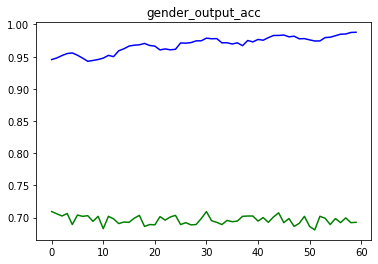

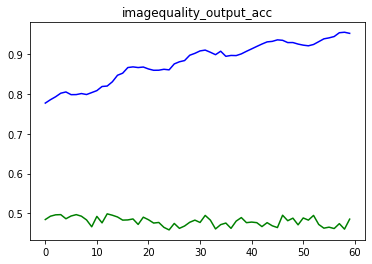

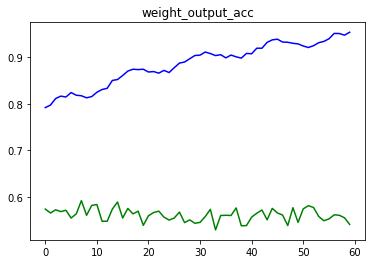

In [35]:
metrics = ['loss', 'age_output_loss', 'bag_output_loss', 'bodypose_output_loss', 'emotion_output_loss', 'footwear_output_loss', 'gender_output_loss', 'imagequality_output_loss', 'weight_output_loss', 'age_output_acc', 'bag_output_acc', 'bodypose_output_acc', 'emotion_output_acc', 'footwear_output_acc', 'gender_output_acc', 'imagequality_output_acc', 'weight_output_acc']
for metric in metrics:
  plot2(metric)